# Exploratory analysis: Yields data

This notebook is for exploring different yield datasets and visualizing relationships between yield, rainfall, and water stress.

It's definitely overkill but I use three different methods for calculating the linear regression and confidence errors:

- Manual calculation in calc_lin_regression
- seaborn's lmplot() in calc_lin_regression
- Another set of calculations with error bars as shown in [this gist](https://github.com/KirstieJane/STATISTICS/blob/master/CIs_LinearRegression.py).

Probably should write my own gist comparing these.

Last updated: 29 April 2020

### Imports

In [37]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
import seaborn as sns
import proplot as plot
import sys
from scipy.stats import t

# We need to add the module path to our system path so 
# that our notebook can find our local objects and code:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

### Functions

In [190]:
def plot_lin_regression(x_var = None, y_var = None, x_str = None, y_str = None, data = None, 
                        x_lab = 'X label here', y_lab = 'Y label here', title = 'Title here', positive = True):
    """ Computes linear regression between independent and dependent variable. 

    Usage: plot_lin_regression(x_var, y_var, x_lab, y_lab, title)
    """
    # Define variables
    X, y = x_var, y_var
    
    # Linear regression
    denominator = X.dot(X) - X.mean() * X.sum()
    m = ( X.dot(y) - y.mean() * X.sum() ) / denominator
    b = (y.mean() * X.dot(X) - X.mean() * X.dot(y) ) / denominator

    y_pred = m*X + b

    # Here I have two figures to make sure they're similar.. 
    # regular plot and seaborn plot with automatic conf. intervals
    fig, ax = plt.subplots(figsize=(5,4))
    plt.figure(figsize=(5,4))

    ax.scatter(X,y,color=(0.2, 0.4, 0.6, 0.6))
    g = sns.lmplot(x_str, y_str, data, ci=95, height=4) # line_kws={'color': 'black'}
    ax.plot(X,y_pred,color=(0.2, 0.4, 0.6, 0.6))

    # Calculate residuals
    res = y - y_pred
    tot = y - y.mean()

    R_squared = 1 - res.dot(res) / tot.dot(tot)
    print(R_squared)
    print('m',m)
    print('b',b)
    
    if positive == True:
        textstr = '\n'.join((
            r'$ y = %.2f$x' % (m, )+'+$  %2.0f$' % (b, ),
            r'$r^2=%.2f$' % (R_squared, ))) 
    else:
        textstr = '\n'.join((
        r'$ y = %.2f$x' % (m, )+'$  %2.0f$' % (b, ),
        r'$r^2=%.2f$' % (R_squared, )))

    props = dict(boxstyle='square', facecolor='lightgray', alpha=0.5)

    # place a text box in upper left in axes coords
    g.fig.text(0.25, 2.27, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    

    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.title(title, fontweight="bold")
    #plt.savefig('output/figures/YieldvsDTM.png', dpi=500)

Version 2 of this; not strictly necessary, but fancy. From [this gist](https://github.com/KirstieJane/STATISTICS/blob/master/CIs_LinearRegression.py).

In [57]:
def lin_fit(x,y):
    '''
    Predicts the values for a best fit between numpy arrays x and y
    Parameters
    ----------
    x: 1D numpy array
    y: 1D numpy array (same length as x)
    Returns
    -------
    p:     parameters for linear fit of x to y
    y_err: 1D array of difference between y and fit values
               (same length as x)
    '''

    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    fit = p(x)

    y_err = y - fit

    return p, y_err

def conf_calc(x, y_err, c_limit=0.975, test_n=50):
    '''
    Calculates confidence interval of regression between x and y
    Parameters
    ----------
    x:       1D numpy array
    y_err:   1D numpy array of residuals (y - fit)
    c_limit: (optional) float number representing the area to the left
             of the critical value in the t-statistic table
             eg: for a 2 tailed 95% confidence interval (the default)
                    c_limit = 0.975
    test_n:  (optional) integer representing numer of equally-spaced
             x-points to predict in the range min(x) to max(x)
    Returns
    -------
    p_x:   1D array, length "test_n", with values spread evenly between
           min(x) and max(x)
    confs: 1D numpy array of predicted y values for x inputs
    '''
    # Define the variables you need
    # to calculate the confidence interval
    mean_x = np.mean(x)			# mean of x
    n = len(x)				# number of samples in origional fit
    tstat = t.ppf(c_limit, n-1)         # appropriate t value
    s_err = np.sum(np.power(y_err,2))	# sum of the squares of the residuals

    # create series of new test x-values to predict for
    p_x = np.linspace(np.min(x),np.max(x),test_n)

    confs = tstat * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))

    return p_x, confs

def ylines_calc(p_x, confs, fit):
    '''
    Calculates the three lines that will be plotted
    Parameters
    ----------
    p_x:   1D array with values spread evenly between min(x) and max(x)
    confs: 1D array with confidence values for each value of p_x
    fit:   Predicted x -> y function (typically derived from np.poly1d)
    Returns
    -------
    p_y:    1D array with values corresponding to fit line (for p_x values)
    upper:  1D array, values corresponding to upper confidence limit line
    lower:  1D array, values corresponding to lower confidence limit line
    '''
    # now predict y based on test x-values
    p_y = fit(p_x)

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    return p_y, lower, upper

def plot_linreg_CIs(x, y, p_x, p_y, lower, upper):

    # set-up the plot
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.title('Linear regression and confidence limits')

    # plot sample data
    plt.plot(x, y, 'o', label='Sample observations')

    # plot line of best fit
    plt.plot(p_x, p_y, 'r-', label='Regression line')

    # plot confidence limits
    plt.plot(p_x, lower, 'r--', label='Lower confidence limit (95%)')
    plt.plot(p_x, upper, 'r--', label='Upper confidence limit (95%)')

    # show the plot
    plt.show()


def confidence_bounds(x, y, c_limit=0.975, test_n=50):
    '''
    Calculates the predicted (trend) line, and lower & upper confidene bounds
    from original x,y measurements
    Parameters
    ----------
    x: 1D numpy array
    y: 1D numpy array (same length as x)
    c_limit: (optional) float number representing the area to the left
             of the critical value in the t-statistic table
             eg: for a 2 tailed 95% confidence interval (the default)
                    c_limit = 0.975
    test_n:  (optional) integer representing numer of equally-spaced
             x-points to predict in the range min(x) to max(x)
    Returns
    -------
    p_x:    1D array with values spread evenly between min(x) and max(x)
            (length test_n)
    p_y:    1D array with values corresponding to fit line (for p_x values)
            (length test_n)
    upper:  1D array, values corresponding to upper confidence limit line
    lower:  1D array, values corresponding to lower confidence limit line
    '''

    # Fit x to y
    p, y_err = lin_fit(x ,y)

    # Calculate confidence intervals
    p_x, confs = conf_calc(x, y_err, c_limit=c_limit, test_n=test_n)

    # Calculate the lines for plotting:
    # The fit line, and lower and upper confidence bounds
    p_y, lower, upper = ylines_calc(p_x, confs, p)

    return p_x, p_y, lower, upper

In [149]:
# calc yield from stress

def calc_yield(stress=None, max_yield = 4000):
    yield_kg_ha = -max_yield*stress + max_yield
    
    if stress > 1:
        raise ValueError("static stress, {stress} is larger than 1".format(
                stress=stress))
    if stress < 0:
        raise ValueError("static stress, {stress} is less than 0".format(
                stress=stress))
    
    return yield_kg_ha

In [3]:
def total_rf_corr(n_sim = 1000, station = 'OL JOGI FARM', texture = 'loam', lgp=210, pd_sim=100): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg stress, total rf
    start = 21 
    end = start + lgp
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    sum_stress = [df[start:end]['stress'].sum() for df in output]
    last_stress = [df['stress'].iloc[-1] for df in output]

    total_rf = [df[start:end]['R'].sum() for df in output]

    return output, avg_stress, total_rf

### Analysis

#### 1. Visualize yield vs. DTM relationship using Hybrid yields dataset from Ridge to Reef

0.8821342568671494
m 38.209721942492855
b -2572.222327532072


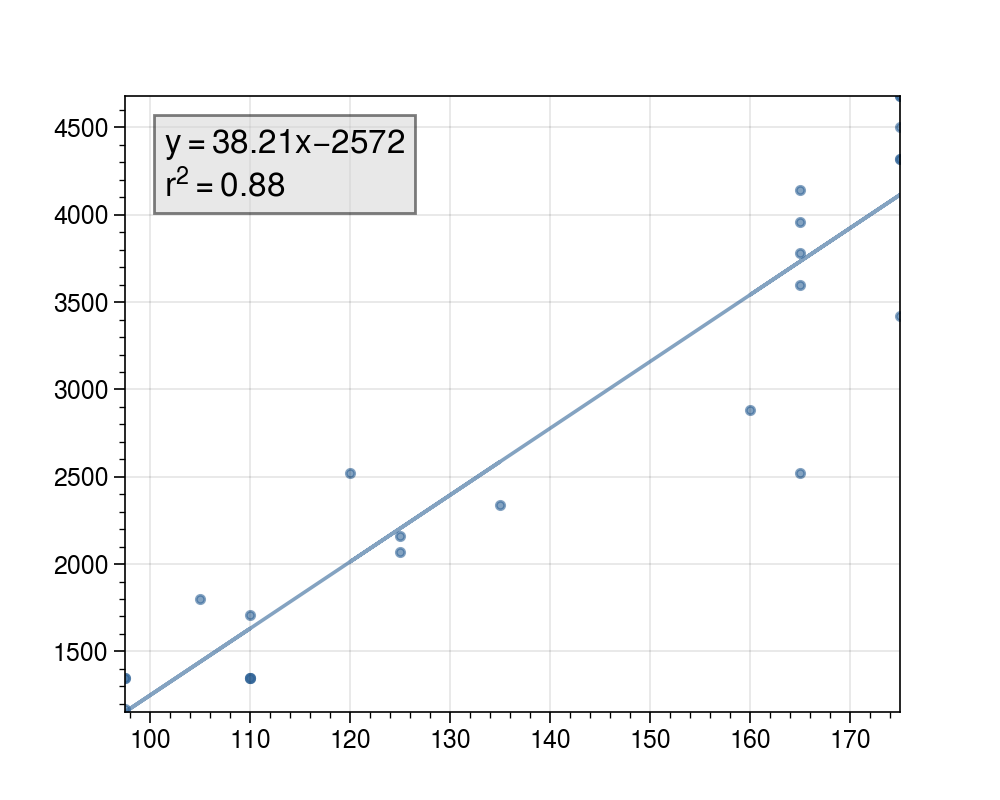

<Figure size 500x400 with 0 Axes>

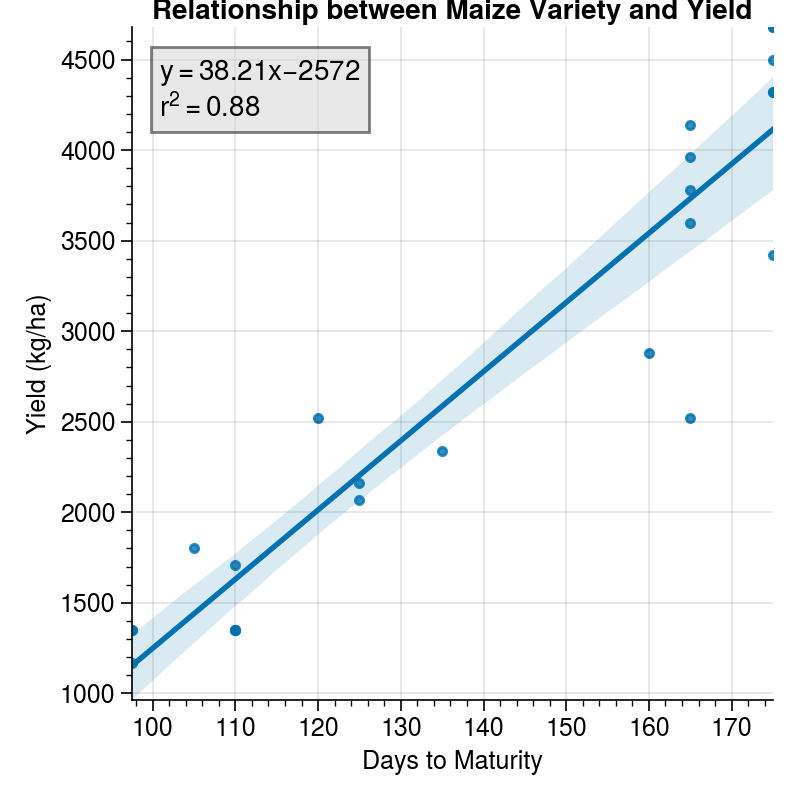

In [183]:
hybrid_data = pd.read_csv('../data/hybrid_yields.csv')

plot_lin_regression(hybrid_data.days_to_maturity, hybrid_data.yield_kg_ha, 'days_to_maturity', 'yield_kg_ha', hybrid_data,'Days to Maturity', 'Yield (kg/ha)', 
                    'Relationship between Maize Variety and Yield', positive=False)

Version two of this because why not

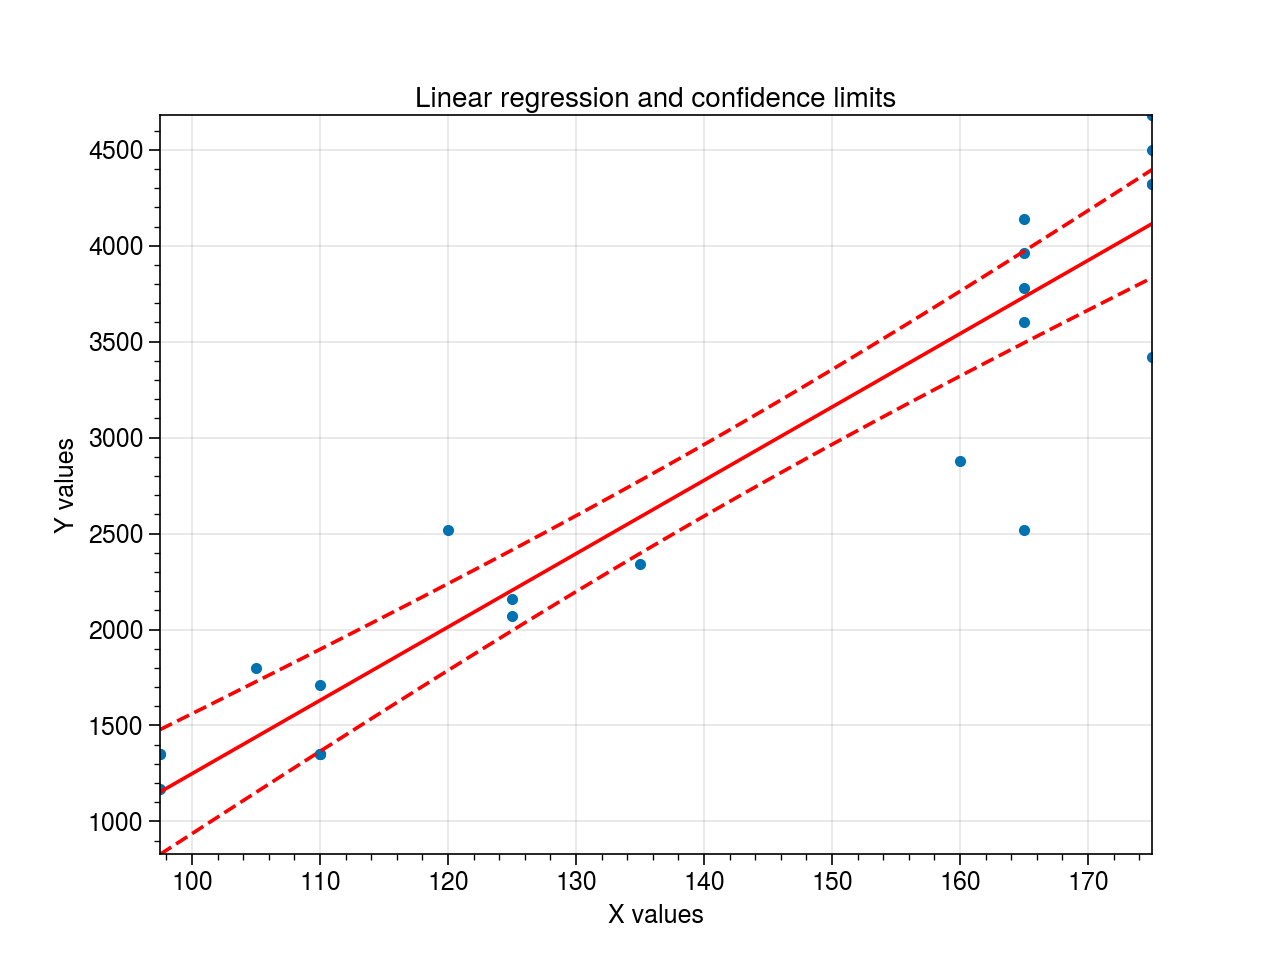

In [143]:
if __name__ == "__main__":
    # Define example data
    x, y = hybrid_data.days_to_maturity, hybrid_data.yield_kg_ha

    # Fit x to y
    p, y_err = lin_fit(x, y)

    # Calculate confidence intervals
    p_x, confs = conf_calc(x, y_err, 0.975)

    # Calculate the lines for plotting:
    # The fit line, and lower and upper confidence bounds
    p_y, lower, upper = ylines_calc(p_x, confs, p)

    # Plot these lines
    plot_linreg_CIs(x, y, p_x, p_y, lower, upper)

#### 2. Linear regression for seasonal rainfall and stress correlation 

In [145]:
output, avg_stress, total_rf = total_rf_corr()

data_tuples = list(zip(total_rf, avg_stress))
df = pd.DataFrame(data_tuples, columns=['TotalRF','AvgStress'])

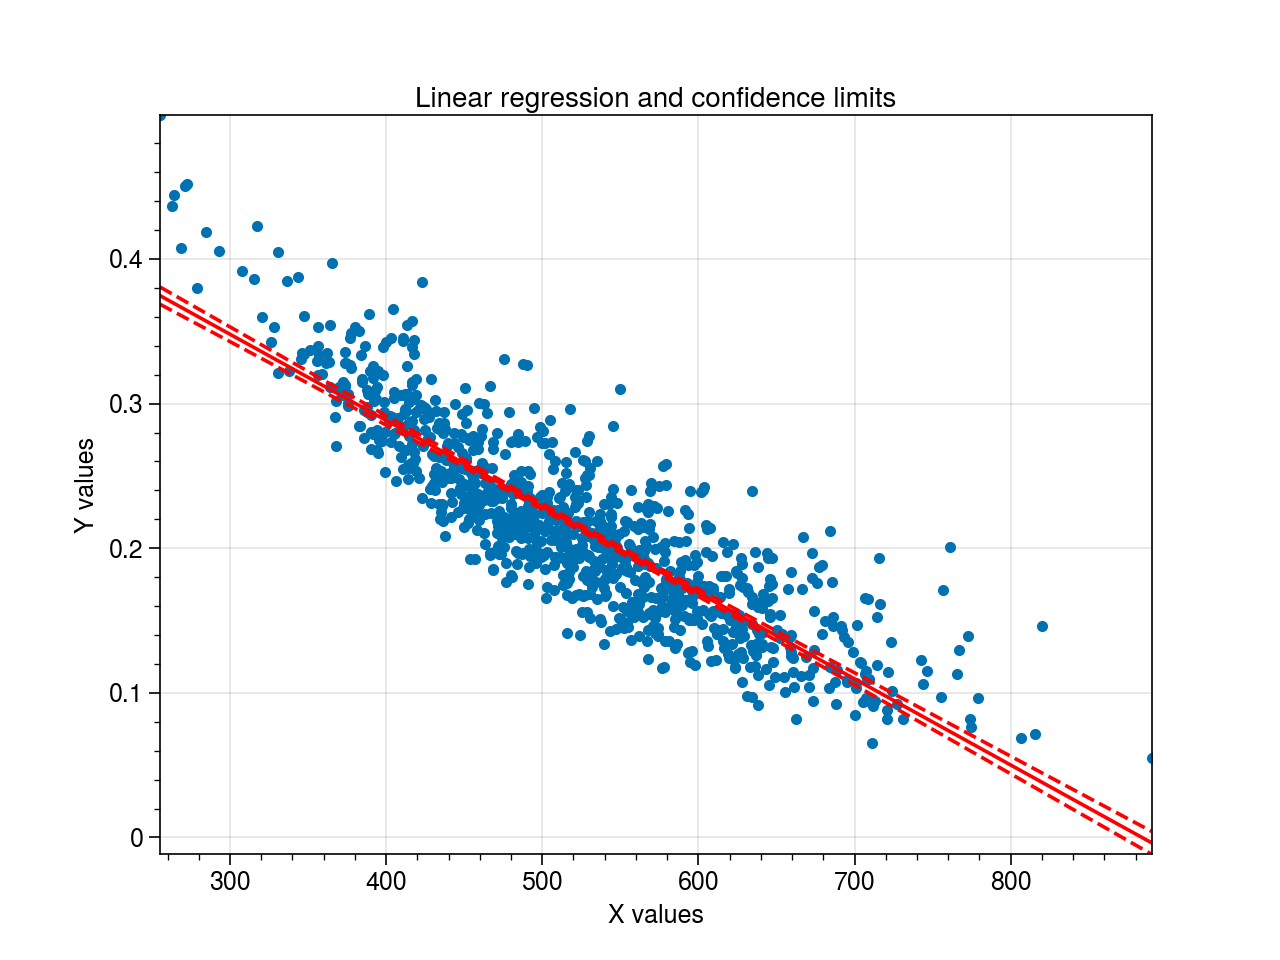

In [192]:
if __name__ == "__main__":
    # Define example data
    x, y = df.TotalRF, df.AvgStress

    # Fit x to y
    p, y_err = lin_fit(x, y)

    # Calculate confidence intervals
    p_x, confs = conf_calc(x, y_err, 0.975)

    # Calculate the lines for plotting:
    # The fit line, and lower and upper confidence bounds
    p_y, lower, upper = ylines_calc(p_x, confs, p)

    # Plot these lines
    plot_linreg_CIs(x, y, p_x, p_y, lower, upper)

0.7592442112915652
m -0.00059571544774834
b 0.5266845450313633


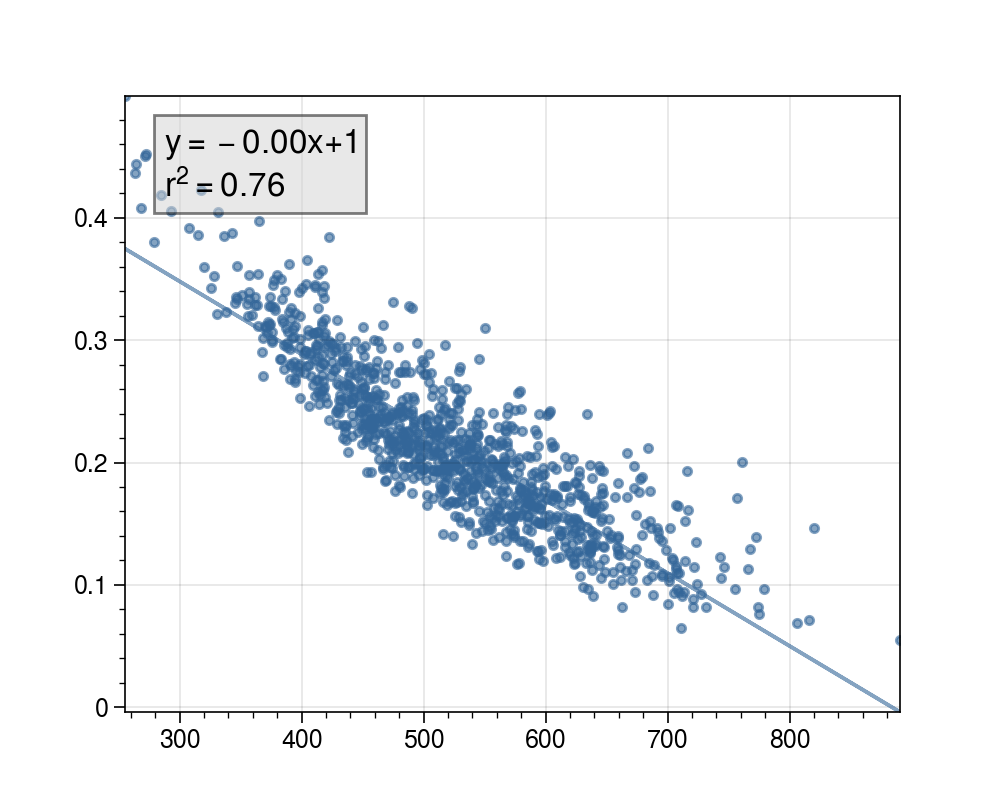

<Figure size 500x400 with 0 Axes>

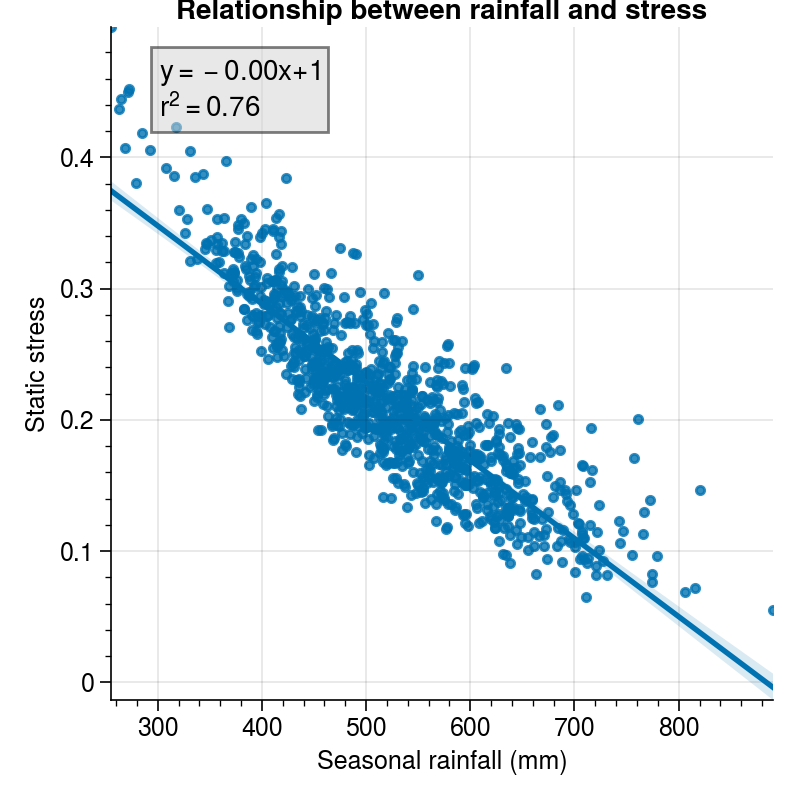

In [193]:
plot_lin_regression(df.TotalRF, df.AvgStress, 'TotalRF','AvgStress',df, 'Seasonal rainfall (mm)', 'Static stress', 'Relationship between rainfall and stress')

#### 3. Convert stress values to yield and do linear regression

0.7592442112915652
m 2.382861790993265
b 1893.2618198745804


3778.8285849088174

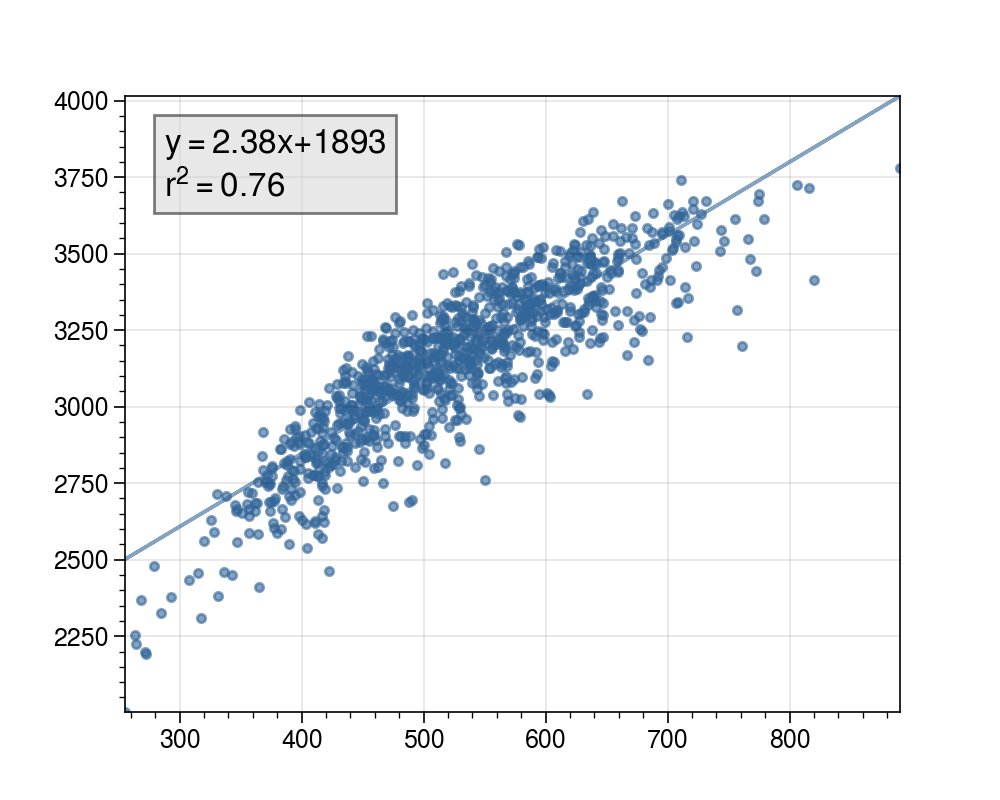

<Figure size 500x400 with 0 Axes>

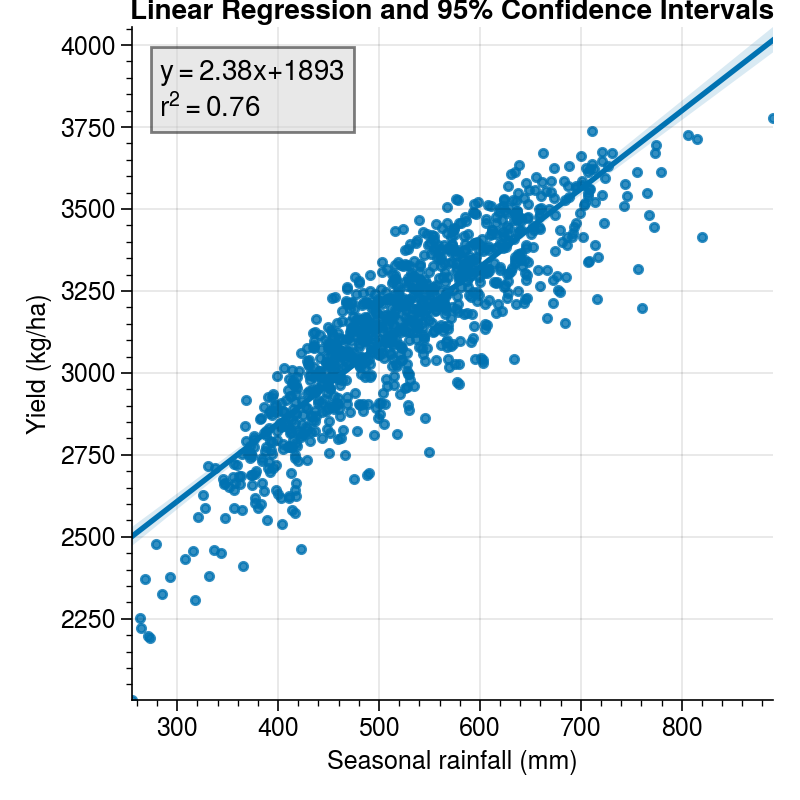

In [194]:
# make a column for yield values from stress
df['Yield'] = pd.Series([calc_yield(i) for i in avg_stress])

plot_lin_regression(df.TotalRF, df.Yield, 'TotalRF', 'Yield',df, 'Seasonal rainfall (mm)', 'Yield (kg/ha)', 'Linear Regression and 95% Confidence Intervals')

max(pd.Series([calc_yield(i) for i in avg_stress]))

#### Can play with other hybrid yields datasets..

0.804031087976912
m 27.790555171045057
b -827.7162088258365


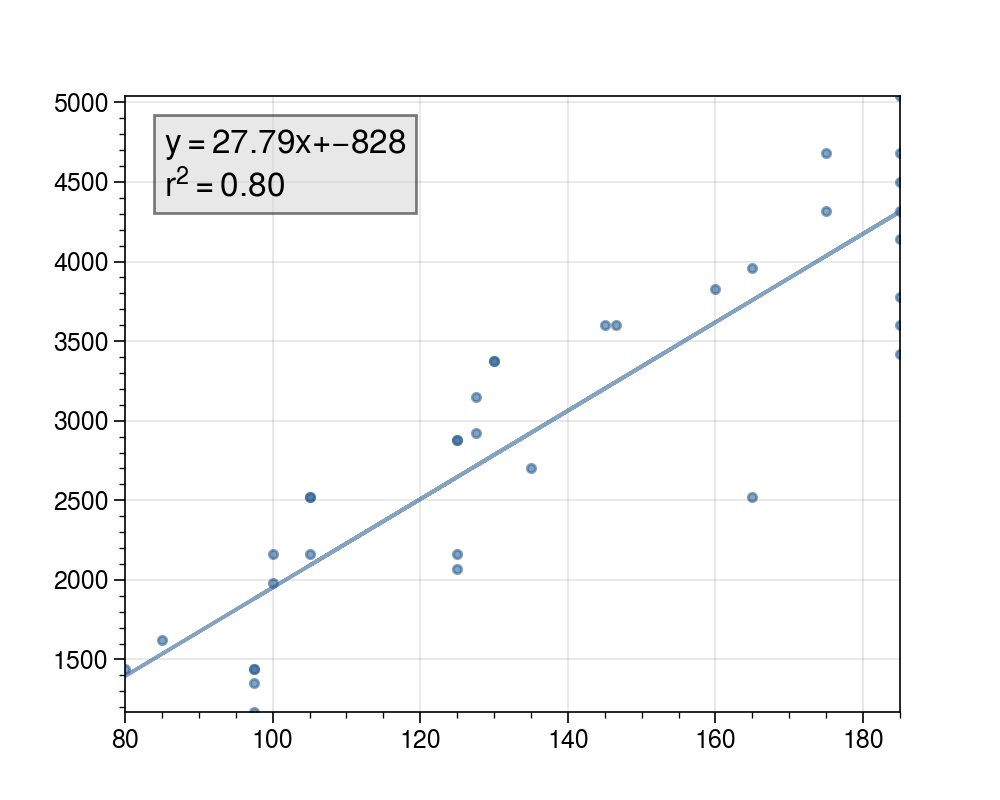

<Figure size 500x400 with 0 Axes>

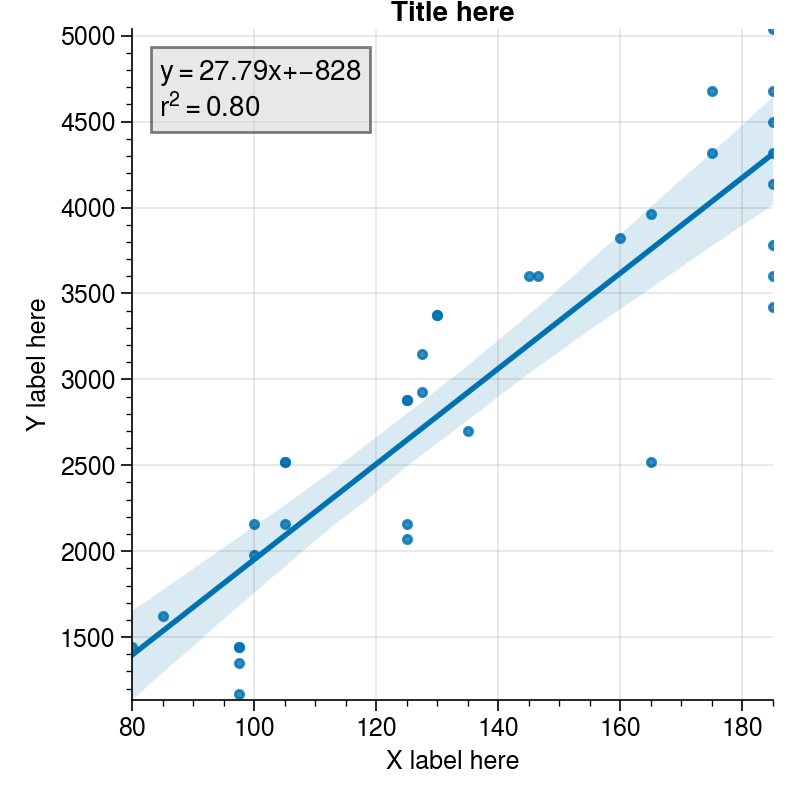

In [196]:
hybrid_data = pd.read_csv('../data/hybrid_yields_v2.csv', usecols = ['VARIETY','Yield_kg','DTM_Avg']).dropna()

hybrid_data
plot_lin_regression(hybrid_data.DTM_Avg, hybrid_data.Yield_kg, 'DTM_Avg','Yield_kg', hybrid_data)
